# Imports et fonctions

In [1]:
#paramètres de l'application
import os
S3 = True
bucket_name = 'p8openclassrooms2'
path_local = 'D:/extrait/*/'

In [2]:
os.environ['PYSPARK_PYTHON']

'/home/ubuntu/miniconda3/envs/openclassrooms/bin/python3.7'

In [3]:
print('PYSPARK_PYTHON ', os.environ['PYSPARK_PYTHON'])

PYSPARK_PYTHON  /home/ubuntu/miniconda3/envs/openclassrooms/bin/python3.7


In [4]:
print('PYSPARK_DRIVER_PYTHON ', os.environ['PYSPARK_DRIVER_PYTHON'])

PYSPARK_DRIVER_PYTHON  /home/ubuntu/miniconda3/envs/openclassrooms/bin/python3.7


In [5]:
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/ubuntu/miniconda3/envs/openclassrooms/bin/python3.7'

In [6]:
import glob
import time
import io
import os
#import numpy as np
from PIL import Image

#import clés AWS
def load_aws_key():
    '''charge ID/KEY de AWS dans variables d'environnement si définies sinon dans le fichier keys.txt'''
    with open('keys.txt','r') as f:
        msg = f.read()
    ID = str(msg).split('\n')[0]
    KEY = msg.split('\n')[1]
    os.environ["AWS_ACCESS_KEY_ID"]=ID
    os.environ["AWS_SECRET_ACCESS_KEY"]=KEY
    return ID, KEY

if S3 is True:
    load_aws_key()
    
#import Spark
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema

#définition packages spark
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11,org.apache.hadoop:hadoop-aws:2.7.0,com.amazonaws:aws-java-sdk:1.7.4,com.amazonaws:aws-java-sdk-s3:1.11.762 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell'


def init_spark_session(S3=False, bucket = '', path_local=''):
    '''Initie une session SPARK
    :s3 : booléen : True = Stockage S3, False = stockage local
    :return SparkContext'''

    if S3 is True:
        path_img = "s3a://"+bucket_name+"/images/*"
        #spark._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
        #spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3-eu-west-3.amazonaws.com")
        #spark._jsc.hadoopConfiguration().set("fs.s3a.aws.access.key", AWS_ACCESS_KEY_ID)
        #spark._jsc.hadoopConfiguration().set("fs.s3a.aws.secret.key", AWS_SECRET_ACCESS_KEY)
        #spark._jsc.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")
        
        #configuration des identifiants Amazon
        #sc._conf.setAll([
        #('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem'), 
        #('fs.s3a.access.key', AWS_ACCESS_KEY_ID),
        #('fs.s3a.secret.key', AWS_SECRET_ACCESS_KEY)])
    else:
        path_img = path_local

    # Instantiation d'une SparkSession et d'un Spark Context
    spark = SparkSession.builder.master('local[*]').appName('P8').getOrCreate()
    sc = spark.sparkContext

    return sc, spark, path_img


In [7]:
#import pyspark
from pyspark import SQLContext
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.image import ImageSchema

from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
#import pyspark

def parse_categorie(path):
    '''Renvoie la catégorie d\'une image à partir de son chemin'''
    if len(path) > 0:
        #catégorie de l'image
        return path.split('/')[-2]
    else:
        return ''

def import_dossier(path):
    '''Renvoie un dataframe spark des images à partir du chemin du dossier.
    :param path: chemin vers le dossier
    :return: dataframe spark contenant toutes les images du dossier'''

    
def load_data(path_img):
    '''Chargement des dataframes: 
    Prend en entrée le répertoire qui contient les sous répertoires contenant les images
    Renvoie en sortie un spark dataframe contenant les images et 
    un spark dataframe contenant les noms des fruits associés'''
    #compteur
    start = time.time()
    #chargement dataframe des images
    
    df_img = spark.read.format("image").load(path) # ne fonctionne pas si il y a des espaces dans le chemin
    #df_img =  ImageSchema.readImages(path_img, dropImageFailures = True)
    print('chargement effectué')
    #récupération chemin à partir des images
    df_img = df_img.withColumn("path", input_file_name())
    #catégorisation des images
    udf_categorie = udf(parse_categorie, StringType())
    df_img = df_img.withColumn('categorie', udf_categorie('path'))
    print('Temps de chargement des images : {} secondes'.format(time.strftime('%S', time.gmtime(time.time()-start))))
    
    return df_img

def preprocess_data(dataframe):
    '''Renvoie le résultat de l'avant dernière couche de chaque image du dataframe via transform du ResNet50
    return un df contenant des vecteurs de dimension 1x2048 '''
    
    from sparkdl import DeepImageFeaturizer
    # DeepImageFeaturizer Applies the model specified by its popular name, 
    # with its prediction layer(s) chopped off
    featurizer = DeepImageFeaturizer(inputCol="image", outputCol="image_preprocessed", modelName="ResNet50")
    output = featurizer.transform(dataframe).select(['path', 'categorie', 'image_preprocessed'])
    del featurizer
    return output

def write_dataframe_parquet(dataframe, path_parquet):
    '''Enregistrement du spark dataframe au format parquet au chemin specifie'''
    try:
        start = time.time()
        dataframe.write.format("parquet").mode('overwrite').save(path_parquet)
        print('Enregistrement effectué.')
            

        print('Temps de sauvegarde : {} secondes'.format(time.strftime('%S', time.gmtime(time.time()-start))))
    except:
        print('L\'Enregistrement a échoué.')
    
    return True

def load_dataframe_parquet(path):
    '''chargement du dataframe : entree parquet / sortie dataframe'''
    return spark.read.format('parquet').load('path')

# Exécution programme

In [8]:
#initialisation instance spark
sc, spark, path = init_spark_session(S3=S3, 
                                     bucket=bucket_name,
                                     path_local = path_local)

In [9]:
path

's3a://p8openclassrooms2/images/*'

In [10]:
sc

<SparkContext master=local[*] appName=P8>

In [11]:
#chargement du dataframe contenant les images, leur chemin et leur catégorie
spark_df = load_data(path)

chargement effectué
Temps de chargement des images : 10 secondes


In [12]:
spark_df.show()

+--------------------+--------------------+--------------+
|               image|                path|     categorie|
+--------------------+--------------------+--------------+
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Mini|
|[s3a://p8openclas...|s3a://p8openclass...|Pineapple_Min

(100, 100, 3)


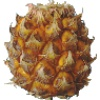

In [13]:
#affichage d'une image
import numpy as np
a = spark_df.first()
b = np.array(a.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1]
print(b.shape)
Image.fromarray(b, 'RGB')

In [14]:
#réduction de dimension et détermination des features : avant dernière couche du réseau de neurone ResNet50
spark_df_preprocessed = preprocess_data(spark_df)

Using TensorFlow backend.


In [15]:
#affichage du dataframe contenant le chemin vers les images, leur catégorie et le vecteur en sortie du Resnet50
spark_df_preprocessed.show()

+--------------------+--------------+--------------------+
|                path|     categorie|  image_preprocessed|
+--------------------+--------------+--------------------+
|s3a://p8openclass...|Pineapple_Mini|[0.29767277836799...|
|s3a://p8openclass...|Pineapple_Mini|[0.19329126179218...|
|s3a://p8openclass...|Pineapple_Mini|[0.17691281437873...|
|s3a://p8openclass...|Pineapple_Mini|[0.07267054915428...|
|s3a://p8openclass...|Pineapple_Mini|[0.29699259996414...|
|s3a://p8openclass...|Pineapple_Mini|[0.66907835006713...|
|s3a://p8openclass...|Pineapple_Mini|[0.13582731783390...|
|s3a://p8openclass...|Pineapple_Mini|[0.34928953647613...|
|s3a://p8openclass...|Pineapple_Mini|[0.15300172567367...|
|s3a://p8openclass...|Pineapple_Mini|[0.24452272057533...|
|s3a://p8openclass...|Pineapple_Mini|[0.44327688217163...|
|s3a://p8openclass...|Pineapple_Mini|[0.38923558592796...|
|s3a://p8openclass...|Pineapple_Mini|[0.08987802267074...|
|s3a://p8openclass...|Pineapple_Mini|[0.13878703117370..

In [16]:
if False:
    spark_df_preprocessed.select("categorie").distinct().show()
    
#exemple de retour en local après 7mn d'exécution'(!):
#+--------------+
#|     categorie|
#+--------------+
#|   Apple_Red_1|
#|        Banana|
#|          Kiwi|
#|Apple_Golden_1|
#+--------------+


In [17]:
#enregistrement des données (format parquet)

if True:
    print('Enregistrement distant S3')
    write_dataframe_parquet(spark_df_preprocessed, 's3a://'+ bucket_name + '/preprocessed_parquet')
else:
    print('Enregistrement local')
    write_dataframe_parquet(spark_df_preprocessed, 'preprocessed_parquet')
    

Enregistrement distant S3
Enregistrement effectué.
Temps de sauvegarde : 06 secondes


In [19]:
#lecture des données enregistrées (format parquet)
if True:
    if True:
        print('lecture distante S3')
        df_parquet = spark.read.format('parquet').load('s3a://' + bucket_name + '/preprocessed_parquet')
    else:
        print('lecture locale')
        df_parquet = spark.read.format('parquet').load('preprocessed_parquet')
    df_parquet.show()

lecture distante S3
+--------------------+------------------+--------------------+
|                path|         categorie|  image_preprocessed|
+--------------------+------------------+--------------------+
|s3a://p8openclass...|          Kohlrabi|[0.87463319301605...|
|s3a://p8openclass...|Melon_Piel_de_Sapo|[0.65477317571640...|
|s3a://p8openclass...|              Pear|[0.19136892259120...|
|s3a://p8openclass...|          Tomato_1|[1.19687497615814...|
|s3a://p8openclass...|          Tomato_1|[2.97429084777832...|
|s3a://p8openclass...|    Apple_Golden_2|[0.73310208320617...|
|s3a://p8openclass...|              Kiwi|[0.29574644565582...|
|s3a://p8openclass...|              Kiwi|[0.0,0.0,0.650950...|
|s3a://p8openclass...|Melon_Piel_de_Sapo|[0.73896831274032...|
|s3a://p8openclass...|      Pepper_Green|[1.70214176177978...|
|s3a://p8openclass...|              Kiwi|[0.32534143328666...|
|s3a://p8openclass...|          Tomato_1|[1.09860467910766...|
|s3a://p8openclass...|          Tom